In [ ]:
# !pip install kmodes
# !pip install plotnine
# !pip install tabulate
# !pip install pandas_gbq 
# !pip install faiss

In [1]:
PROJECT='driven-insights' 

BUCKET='Carwash'
REGION='us-east1'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn import preprocessing
from sklearn import cluster
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import date

### Change Working Directory

In [ ]:
# Import the os module
import os

path = '/home/jupyter/Clustering/Member_Clustering'

try:
    os.chdir(path)
    print("Current working directory: {0}".format(os.getcwd()))
except FileNotFoundError:
    print("Directory: {0} does not exist".format(path))
except NotADirectoryError:
    print("{0} is not a directory".format(path))
except PermissionError:
    print("You do not have permissions to change to {0}".format(path))

In [ ]:
import os
directory_path = os.getcwd()
print("My current directory is : " + directory_path)
folder_name = os.path.basename(directory_path)
print("My directory name is : " + folder_name)

### Importing Data

In [3]:
from google.cloud import bigquery
bq = bigquery.Client(project=PROJECT)

query = """

SELECT * 
FROM `driven-insights.steven_jordan.Member_Clustering_Customer_Level_v2`

"""

dataori = bq.query(query, location='US').to_dataframe()

In [4]:
data = dataori

In [5]:
df1 = data[[
    
    # 'customerid',
    'memberstatus',
    # 'memberoriginalstartdate',
    # 'memberstartdate',
    # 'firsttransaction',
    # 'MemberExpirationDate',
    # 'month',
    # 'lastrechargedate',
    # 'calcstart',
    # 'calclastrecharge',
    # 'calcexpiration',
    # 'spring',
    # 'summer',
    # 'fall',
    # 'winter',
    'membertenure',
    'repeatmember',
    # 'overlapmembership',
    # 'samedaypurchase',
    # 'MCC',
    # 'T5',
    # 'MAA',
    # 'revenue',
    # 'discounts',
    # 'recency',
    # 'frequency',
    # 'sitesvisited',
    'median_days_between_member_trips',
    # 'membersitename',
    # 'membersite',
    # 'mostvisited',
    # 'median_miles_to_site',
    # 'displaced_member',
    # 'acquisitionsource',
    # 'ConvertedMember',
    # 'CRM_Message_Count',
    # 'memberlastknownstatusdescription',
    # 'customercity',
    # 'customerstate',
    # 'customerpostal',
    # 'customerlatitude',
    # 'customerlongitude',
    # 'vehicleyear',
    # 'vehiclemake',
    # 'vehiclemodel',
    # 'lifestagecluster',
    # 'occupation',
    # 'race',
    # 'ownerrenter',
    # 'householdincome',
    # 'homemarketvalue',
    # 'generation',
    # 'birthyear',
    # 'maritalstatus',
    # 'gender',
    # 'education',
    # 'numberchildren',
    # 'phonecollected',
    # 'emailcollected',
    # 'addresscollected',
    'revenue_per_member_month',
    'frequency_per_member_month',
    'discounts_per_member_month'
    #'rownum'



]]

In [6]:
print(df1.shape)
df1.info()

(229155, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229155 entries, 0 to 229154
Data columns (total 7 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   memberstatus                      229155 non-null  object 
 1   membertenure                      229155 non-null  float64
 2   repeatmember                      229155 non-null  bool   
 3   median_days_between_member_trips  193383 non-null  float64
 4   revenue_per_member_month          229155 non-null  float64
 5   frequency_per_member_month        229155 non-null  float64
 6   discounts_per_member_month        89133 non-null   float64
dtypes: bool(1), float64(5), object(1)
memory usage: 10.7+ MB


In [7]:
#converting datatypes
df1 = df1.astype({#"MCC": np.object, "T5": np.object, "MAA": np.object, 
                 "repeatmember": np.object,
                 #'spring': np.float, 'summer': np.float, 'fall': np.float, 'winter': np.float,
                 #'sitesvisited': np.float,
                 #'vehicleyear': np.float
                 })

### Seperating Numeric and Categorical Variables

In [8]:
# Get the position of categorical (without boolean) columns
catColumnsPosTEMP = [df1.columns.get_loc(col) for col in list(df1.select_dtypes('object').columns)]
print('Categorical(no Bool) columns           : {}'.format(list(df1.select_dtypes('object').columns)))
print('Categorical(no Bool) columns position  : {}'.format(catColumnsPosTEMP))

Categorical(no Bool) columns           : ['memberstatus', 'repeatmember']
Categorical(no Bool) columns position  : [0, 2]


In [ ]:
# # Get the position of categorical columns
# catColumnsPos = [df1.columns.get_loc(col) for col in list(df1.select_dtypes(['object', 'bool']).columns)]
# print('Categorical columns           : {}'.format(list(df1.select_dtypes(['object', 'bool']).columns)))
# print('Categorical columns position  : {}'.format(catColumnsPos))

In [9]:
# Get columns whose data type is numeric 
filteredColumns_num = df1.dtypes[df1.dtypes == np.float64]
# list of columns whose data type is numeric
listOfColumnNames = list(filteredColumns_num.index)
print(listOfColumnNames)
print(len(listOfColumnNames))

['membertenure', 'median_days_between_member_trips', 'revenue_per_member_month', 'frequency_per_member_month', 'discounts_per_member_month']
5


### Imputation

In [10]:
df1.isnull().sum()

memberstatus                             0
membertenure                             0
repeatmember                             0
median_days_between_member_trips     35772
revenue_per_member_month                 0
frequency_per_member_month               0
discounts_per_member_month          140022
dtype: int64

In [ ]:
# Categorical variables replace with Unknown
# df1[['memberstatus', 'ownerrenter', 'householdincome', 'homemarketvalue', 'generation', 'maritalstatus', 'gender', 'education', 'numberchildren']] = df1[['memberstatus', 'ownerrenter', 'householdincome', 'homemarketvalue', 'generation', 'maritalstatus', 'gender', 'education', 'numberchildren']].fillna("Unknown")

In [11]:
# Numeric variables imputation
#df1["discounts"].fillna(0, inplace = True)
df1["median_days_between_member_trips"].fillna(df1["median_days_between_member_trips"].max(), inplace = True)
#df1["vehicleyear"].fillna(df1["vehicleyear"].median(), inplace = True)
# df1["revenue_per_member_month"].fillna(0, inplace = True)
df1["discounts_per_member_month"].fillna(0, inplace = True)

In [12]:
df1 = df1.dropna()

In [13]:
print(df1.shape)
df1.head()

(229155, 7)


,memberstatus,membertenure,repeatmember,median_days_between_member_trips,revenue_per_member_month,frequency_per_member_month,discounts_per_member_month
0,Former Member,8.0,True,26.0,30.625000,0.250000,-2.625000
1,Former Member,28.0,True,2.0,26.242500,9.321429,-0.642857
2,Former Member,14.0,True,7.0,31.848571,3.357143,0.000000
3,Former Member,5.0,False,4.0,30.800000,5.000000,0.000000
4,Former Member,18.0,True,8.0,3.871111,0.888889,-0.500000


In [14]:
df1.isnull().sum()

memberstatus                        0
membertenure                        0
repeatmember                        0
median_days_between_member_trips    0
revenue_per_member_month            0
frequency_per_member_month          0
discounts_per_member_month          0
dtype: int64

In [ ]:
# df1.shape

In [15]:
# selecting the numeric variables out from DF for scaling
x = df1[['membertenure', 'median_days_between_member_trips', 'revenue_per_member_month', 'frequency_per_member_month', 'discounts_per_member_month']]
x.describe()

,membertenure,median_days_between_member_trips,revenue_per_member_month,frequency_per_member_month,discounts_per_member_month
count,229155.000000,229155.000000,229155.000000,229155.000000,229155.000000
mean,10.952897,173.815169,23.492680,2.424887,-2.944608
std,13.157832,377.584504,15.298607,2.936235,7.922919
min,1.000000,0.000000,-67.410000,0.011111,-111.980000
25%,2.000000,5.000000,13.330000,1.000000,-1.948109
50%,6.000000,9.000000,25.000000,1.714286,0.000000
75%,14.000000,20.000000,32.740000,3.000000,0.000000
max,328.000000,1050.000000,720.980000,213.000000,0.000000


### VIF

In [ ]:
# # run VIF for numeric variables
# num_col = df1[['membertenure',  'revenue_per_member_month', 'frequency_per_member_month', 'discounts_per_member_month']]

# # VIF dataframe
# vif_num = pd.DataFrame()
# vif_num["feature"] = num_col.columns
  
# # calculating VIF for each numeric feature
# vif_num["VIF"] = [variance_inflation_factor(num_col.values, i)
#                           for i in range(len(num_col.columns))]
  
# print(vif_num)

In [16]:
# run VIF for all the variables
dummies_col = pd.get_dummies(df1, drop_first=True, columns= ['memberstatus', 'repeatmember'])
dummies_col.head()
# VIF dataframe
vif_dummies = pd.DataFrame()
vif_dummies["feature"] = dummies_col.columns
  
# calculating VIF for each categorical feature
vif_dummies["VIF"] = [variance_inflation_factor(dummies_col.values, i)
                          for i in range(len(dummies_col.columns))]
  
print(vif_dummies)
# print(vif_dummies[vif_dummies["VIF"] > 5])

                            feature       VIF
0                      membertenure  1.708870
1  median_days_between_member_trips  1.207296
2          revenue_per_member_month  2.540699
3        frequency_per_member_month  1.898659
4        discounts_per_member_month  1.228684
5        memberstatus_Former Member  2.511497
6                 repeatmember_True  1.663203


### Scaling Numeric and Dummy Categorical Variables

In [17]:
# Normalize the variables to have mean=0 and sd=1
clusterdata=x.copy()
for i in range(clusterdata.shape[1]):
    clusterdata.iloc[:,i] = preprocessing.scale(clusterdata.iloc[:,i].astype('float64'))

In [18]:
clusterdata.describe()

,membertenure,median_days_between_member_trips,revenue_per_member_month,frequency_per_member_month,discounts_per_member_month
count,2.291550e+05,2.291550e+05,2.291550e+05,2.291550e+05,2.291550e+05
mean,7.649020e-16,-5.796725e-17,1.198400e-15,-1.189306e-16,-1.328019e-15
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-7.564254e-01,-4.603355e-01,-5.941906e+00,-8.220668e-01,-1.376205e+01
25%,-6.804249e-01,-4.470934e-01,-6.642894e-01,-4.852780e-01,1.257745e-01
50%,-3.764228e-01,-4.364997e-01,9.852686e-02,-2.420116e-01,3.716578e-01
75%,2.315815e-01,-4.073671e-01,6.044564e-01,1.958679e-01,3.716578e-01
max,2.409575e+01,2.320505e+00,4.559166e+01,7.171619e+01,3.716578e-01


In [19]:
clusterdata.shape

(229155, 5)

In [20]:
y = df1[['memberstatus', 'repeatmember']]

In [21]:
yd = pd.get_dummies(y, drop_first=True)

In [22]:
print(yd.shape)
yd.head()

(229155, 2)


,memberstatus_Former Member,repeatmember_True
0,1,1
1,1,1
2,1,1
3,1,0
4,1,1


In [23]:
# Combine scaled and dummied variables for a new df
df2 = pd.concat([clusterdata,yd], axis=1, join='inner')

In [ ]:
# df2 = clusterdata

In [24]:
print(df2.shape)
df2.head()

(229155, 7)


,membertenure,median_days_between_member_trips,revenue_per_member_month,frequency_per_member_month,discounts_per_member_month,memberstatus_Former Member,repeatmember_True
0,-0.224422,-0.391477,0.466208,-0.740708,0.040340,1,1
1,1.295589,-0.455039,0.179744,2.348775,0.290519,1,1
2,0.231581,-0.441797,0.546188,0.317501,0.371658,1,1
3,-0.452423,-0.449742,0.477647,0.877014,0.371658,1,0
4,0.535584,-0.439148,-1.282575,-0.523119,0.308550,1,1


### Elbow Method

In [25]:
from scipy.spatial.distance import cdist
clusters=range(1,11)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(df2)
    clusassign=model.predict(df2)
    meandist.append(sum(np.min(cdist(df2, model.cluster_centers_, 'euclidean'), axis=1)) 
    / df2.shape[0])

In [26]:
cdist(df2, model.cluster_centers_, 'euclidean')

array([[ 1.1440056 ,  4.24255197,  1.54048648, ..., 18.75707343,
         3.13439643,  2.30904661],
       [ 2.96817039,  3.83389756,  3.18982305, ..., 15.87095745,
         1.76554459,  3.65416064],
       [ 1.03971354,  3.87151694,  1.63131173, ..., 17.72702194,
         2.19701007,  2.53509074],
       ...,
       [ 3.61809526,  5.44975299,  3.03104125, ..., 19.10173807,
         4.49100798,  4.00974731],
       [ 1.14085624,  4.62231862,  1.13456729, ..., 18.60211869,
         2.98934568,  2.48606087],
       [ 4.55241128,  0.68533123,  4.47646877, ..., 19.3588591 ,
         5.40567291,  5.39461866]])

In [27]:
df2.shape[0]

229155

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

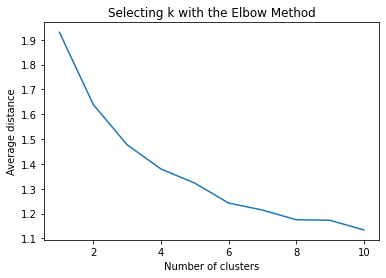

In [28]:
#plt.figure(figsize=(15,5))
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')

### Silhouette Score

In [ ]:
# for n_cluster in [2,3,4,5,6,7,8,9,10]:
#     kmeans = KMeans(n_clusters=n_cluster).fit(df2)
    
#     silhouette_avg = silhouette_score(
#         df2, kmeans.labels_)
    
#     print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))

In [ ]:
# # A list holds the silhouette coefficients for each k
# silhouette_coefficients = []

# # Notice you start at 2 clusters for silhouette coefficient
# for k in range(2, 11):
#      kmeans = KMeans(n_clusters=k)
#      kmeans.fit(df2)
#      score = silhouette_score(df2, kmeans.labels_)
#      silhouette_coefficients.append(score)

In [ ]:
# plt.style.use("fivethirtyeight")
# plt.plot(range(2, 11), silhouette_coefficients)
# plt.xticks(range(2, 11))
# plt.xlabel("Number of Clusters")
# plt.ylabel("Silhouette Coefficient")
# plt.show()

In [29]:
# Define the model
kmeans_model_a = KMeans(n_clusters = 6, init='k-means++', random_state = 42)

# Fit into our dataset
kmeans_predict_a = kmeans_model_a.fit_predict(df2)

In [ ]:
# # Define the model
# kmeans_model_b = KMeans(n_clusters = 7, init='k-means++', random_state = 42)

# # Fit into our dataset
# kmeans_predict_b = kmeans_model_b.fit_predict(df2)

In [30]:
# The lowest SSE value
print(kmeans_model_a.inertia_)
# Final locations of the centroid
print(kmeans_model_a.cluster_centers_)
# The number of iterations required to converge
print(kmeans_model_a.n_iter_)

524818.0638565198
[[ 2.19800342 -0.41152585 -0.41262317 -0.26322956  0.3033323   0.58144626
   0.61575332]
 [-0.20425578 -0.42878903  0.59284979  0.0841325   0.11567629  0.65776373
   0.23537127]
 [-0.5639668   2.31904609 -0.41702127 -0.61750271 -0.00667199  0.62675497
   0.03275938]
 [-0.20797857 -0.42674809 -0.67594546 -0.12518521  0.21986867  0.72688805
   0.28965137]
 [-0.32999319 -0.44168218  1.22241129  3.54580303 -0.03537665  0.85043904
   0.39254354]
 [-0.73043799  0.22729771 -0.93679139  0.24606947 -4.6220724   0.99792316
   0.07995846]]
28


In [ ]:
# # The lowest SSE value
# print(kmeans_model_b.inertia_)
# # Final locations of the centroid
# print(kmeans_model_b.cluster_centers_)
# # The number of iterations required to converge
# print(kmeans_model_b.n_iter_)

In [31]:
######## change if # of clusters changed ########
#################################################
df1['Cluster'] = kmeans_predict_a

In [32]:
df1

,memberstatus,membertenure,repeatmember,median_days_between_member_trips,revenue_per_member_month,frequency_per_member_month,discounts_per_member_month,Cluster
0,Former Member,8.0,True,26.0,30.625000,0.250000,-2.625000,1
1,Former Member,28.0,True,2.0,26.242500,9.321429,-0.642857,4
2,Former Member,14.0,True,7.0,31.848571,3.357143,0.000000,1
3,Former Member,5.0,False,4.0,30.800000,5.000000,0.000000,1
4,Former Member,18.0,True,8.0,3.871111,0.888889,-0.500000,3
...,...,...,...,...,...,...,...,...
229150,Active Member,1.0,False,1050.0,0.010000,1.000000,0.000000,2
229151,Active Member,1.0,False,1050.0,0.010000,1.000000,0.000000,2
229152,Active Member,1.0,False,1050.0,0.010000,1.000000,0.000000,2
229153,Active Member,2.0,False,1.0,22.995000,1.000000,0.000000,3


### Prepare Exporting Data

In [33]:
data.shape

(229155, 62)

In [34]:
datana = data.dropna(axis=0, how='all', subset=["revenue_per_member_month","revenue_per_member_month"])

In [35]:
# swap the imputated columns
datana[["median_days_between_member_trips", "discounts_per_member_month"]] = df1[["median_days_between_member_trips", "discounts_per_member_month"]]

In [36]:
export = datana.iloc[:,0:61]

In [37]:
print(export.shape)
export.head()

(229155, 61)


,customerid,memberstatus,memberoriginalstartdate,memberstartdate,firsttransaction,MemberExpirationDate,month,lastrechargedate,calcstart,calclastrecharge,...,maritalstatus,gender,education,numberchildren,phonecollected,emailcollected,addresscollected,revenue_per_member_month,frequency_per_member_month,discounts_per_member_month
0,1000000203689,Former Member,2021-05-21,2021-05-21,2021-05-26,None,5,2021-06-26,2021-05-21,2021-06-26,...,Single,Female,Completed High School,Children,True,True,True,30.625000,0.250000,-2.625000
1,1000001147756,Former Member,2021-02-19,2021-02-19,2021-02-19,None,2,2021-04-19,2021-02-19,2021-04-19,...,Single,Male,Completed High School,Children,True,True,True,26.242500,9.321429,-0.642857
2,1000002762037,Former Member,2021-07-20,2021-07-20,2021-07-20,2021-12-20,7,2021-11-20,2021-07-20,2021-11-20,...,Married,Male,Completed Graduate School,Children,True,True,True,31.848571,3.357143,0.000000
3,1000005528183,Former Member,2020-09-05,2020-09-05,2020-09-05,2021-02-05,9,2021-01-05,2020-09-05,2021-01-05,...,Single,Male,None,Children,False,False,True,30.800000,5.000000,0.000000
4,1000006380346,Former Member,2021-01-23,2021-01-23,2021-01-23,None,1,2021-12-15,2021-01-23,2021-12-15,...,Single,Male,Completed Graduate School,Children,True,True,True,3.871111,0.888889,-0.500000


In [38]:
######## change if # of clusters changed ########
#################################################
export['Cluster'] = kmeans_predict_a
export['Cluster'] = export['Cluster'].replace(regex = {0 : "Discount Seeker", 1 : "Low Revenue", 2 : "High Tenure", 3 : "Discount Seekers", 4 : "Platinum Members", 5 : "High Frequency"})
export['RunDate'] = date.today()

In [39]:
print(export.shape)
export

(229155, 63)


,customerid,memberstatus,memberoriginalstartdate,memberstartdate,firsttransaction,MemberExpirationDate,month,lastrechargedate,calcstart,calclastrecharge,...,education,numberchildren,phonecollected,emailcollected,addresscollected,revenue_per_member_month,frequency_per_member_month,discounts_per_member_month,Cluster,RunDate
0,1000000203689,Former Member,2021-05-21,2021-05-21,2021-05-26,None,5,2021-06-26,2021-05-21,2021-06-26,...,Completed High School,Children,True,True,True,30.625000,0.250000,-2.625000,Low Revenue,2021-12-27
1,1000001147756,Former Member,2021-02-19,2021-02-19,2021-02-19,None,2,2021-04-19,2021-02-19,2021-04-19,...,Completed High School,Children,True,True,True,26.242500,9.321429,-0.642857,Platinum Members,2021-12-27
2,1000002762037,Former Member,2021-07-20,2021-07-20,2021-07-20,2021-12-20,7,2021-11-20,2021-07-20,2021-11-20,...,Completed Graduate School,Children,True,True,True,31.848571,3.357143,0.000000,Low Revenue,2021-12-27
3,1000005528183,Former Member,2020-09-05,2020-09-05,2020-09-05,2021-02-05,9,2021-01-05,2020-09-05,2021-01-05,...,None,Children,False,False,True,30.800000,5.000000,0.000000,Low Revenue,2021-12-27
4,1000006380346,Former Member,2021-01-23,2021-01-23,2021-01-23,None,1,2021-12-15,2021-01-23,2021-12-15,...,Completed Graduate School,Children,True,True,True,3.871111,0.888889,-0.500000,Discount Seekers,2021-12-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229150,1000022694745,Active Member,2021-12-09,2021-12-09,2021-12-09,None,12,2021-12-09,2021-12-09,2021-12-09,...,Completed College,Children,True,True,True,0.010000,1.000000,0.000000,High Tenure,2021-12-27
229151,1000022729336,Active Member,2021-12-11,2021-12-11,2021-12-11,None,12,2021-12-11,2021-12-11,2021-12-11,...,None,Children,True,False,True,0.010000,1.000000,0.000000,High Tenure,2021-12-27
229152,1000022791141,Active Member,2021-12-16,2021-12-16,2021-12-16,None,12,2021-12-16,2021-12-16,2021-12-16,...,Completed High School,Children,True,True,True,0.010000,1.000000,0.000000,High Tenure,2021-12-27
229153,1000022797878,Active Member,2021-11-04,2021-11-04,2021-11-04,None,11,2021-12-04,2021-11-04,2021-12-04,...,Completed College,Children,True,False,True,22.995000,1.000000,0.000000,Discount Seekers,2021-12-27


In [40]:
# change date to string for creating table in BigQuery
export[["RunDate", "memberoriginalstartdate", "memberstartdate", "firsttransaction", "MemberExpirationDate", "lastrechargedate", "calcstart", "calclastrecharge", "calcexpiration"]] = export[["RunDate", "memberoriginalstartdate", "memberstartdate", "firsttransaction", "MemberExpirationDate", "lastrechargedate", "calcstart", "calclastrecharge", "calcexpiration"]].astype('string')

In [ ]:
export = export_lastweek.append(export)

In [41]:
import pandas_gbq



export.to_gbq('tia_tsou.Member_Clustering_K-Means_test', 'driven-insights', if_exists='replace')

100% 1/1 [00:00<00:00, 5645.09it/s]


In [ ]:
#export.to_csv(r'Member_Clustering_K-Means_6_Clusters_12172021_.csv', header=True, index=False, encoding='utf-8')

In [42]:
export_lastweek = export

### Clustering Performance Evaluation

In [ ]:
# from sklearn import metrics
# from sklearn.metrics import pairwise_distances

In [ ]:
# labels_a = kmeans_model_a.labels_

In [ ]:
# labels_b = kmeans_model_b.labels_

##### Silhouette Coefficient

In [ ]:
# metrics.silhouette_score(df2, labels_a, metric='euclidean')

In [ ]:
# metrics.silhouette_score(df2, labels_b, metric='euclidean')

The Silhouette score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.

##### Calinski-Harabasz Index¶

In [ ]:
# metrics.calinski_harabasz_score(df2, labels_a)

In [ ]:
# metrics.calinski_harabasz_score(df2, labels_b)

The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

##### Davies-Bouldin Index

In [ ]:
# from sklearn.metrics import davies_bouldin_score

In [ ]:
# davies_bouldin_score(df2, labels_a)

In [ ]:
# davies_bouldin_score(df2, labels_b)

- Zero is the lowest possible score. Values closer to zero indicate a better partition.
- The average ‘similarity’ between clusters. Similarity is a measure that compares the distance between clusters with the size of the clusters themselves